# ⌨️ 사전 학습 모델 활용하기

## 사전 학습 모델이란?

사전 학습 모델(Pre-trained Model)은 이미 학습된 가중치를 가진 모델을 의미하며, 새로운 작업을 시작할 때 처음부터 모델을 학습시키지 않아도 된다는 점에서 매우 유용합니다. 인공지능 모델은 크게 모델 구조(Neural Network)와 모델 가중치(Weights)로 구성되어 있습니다:
- 모델 구조(Neural Network): 특정 작업(예: 이미지 분류, 객체 탐지)에 적합한 신경망 설계 (일반적으로 Class 자료형)
- 모델 가중치(Weights): 특정 데이터셋에서 학습한 파라미터 값으로, 적용 분야에 따라 서로 다른 데이터셋을 활용하여 모델 가중치가 달라짐

이러한 모델 가중치를 처음부터 학습시키려면 많은 시간과 자원이 필요한데, 사전 학습 모델은 이러한 어려움을 해결해줍니다. 마치, 숙련된 개발자가 이미 작성해놓은 잘 동작하는 라이브러리를 불러와 활용하는 것과 같습니다.

## torchvision이 제공하는 사전 학습 모델

`torchvision.models` 모듈에는 많이 사용하는 작업들을 위한 모델 구조와 함께 사전 학습된 모델 가중치도 제공하고 있습니다:
- 이미지 분류(Classification): ResNet, VGG, MobileNet 등
- 객체 탐지(Object Detection): Faster R-CNN, RetinaNet, YOLO 등
- 이미지 세분화(Segmentation): DeepLabV3, FCN 등
- 키포인트 검출(Keypoint Detection): Keypoint R-CNN 등
- 비디오 분류(Video Classification): R3D, MC3, C2D 등

torchvision에서 제공하는 작업 종류별 제공하는 사전 학습 모델에 대해서는 다음 문서를 참고해주세요:

https://pytorch.org/vision/stable/models.html

# torchvision이 제공하는 사전 학습 모델 사용하기

먼저 torchvision에서 제공하는 Faster R-CNN(Region-based Convolutional Neural Network) 모델을 가져와 사용해보겠습니다. Faster R-CNN은 객체 탐지(Object Detection) 작업에 최적화된 딥러닝 모델로, 	입력 이미지에서 여러 객체를 탐지하고, 각 객체의 바운딩 박스와 클래스 레이블을 예측합니다.

## 이미지 내려받기

```{note}
앞에서 다운로드한 `sample.jpg` 파일이 존재하면 다시 다운로드하지 않아도 됩니다.
```

In [1]:
# 이미지 준비에 필요한 라이브러리 불러오기
from io import BytesIO
import requests
from PIL import Image

# URL로부터 이미지를 다운로드하고 파일로 저장하는 함수
def save_image_from_url(image_url, file_path='./temp.jpg'):
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()

        image = Image.open(BytesIO(response.content))
        image.save(file_path)
        print(f'Image saved successfully to {file_path}')
    except requests.exceptions.RequestException as e:
        print(f'Error downloading image: {e}')
    except Exception as e:
        print(f'Error saving image: {e}')

# URL로부터 이미지를 내려받아 sample.jpg로 저장
img_url = 'https://images.unsplash.com/photo-1687779176476-55920ac3f400?q=80&w=1024&auto=format'
save_image_from_url(img_url, 'sample.jpg')

Image saved successfully to sample.jpg


## 사전 학습된 가중치 가져오기

먼저, Faster R-CNN 모델의 사전 학습된 모델의 가중치를 살펴보겠습니다. torchvision의 가중치는 `torchvision.models._api.Weights`를 상속받아 정의하며, 다음과 같은 3가지 속성들을 공통적으로 갖습니다.

| 이름 | 자료형 | 설명 |
| --- | -- | --- |
| `url` | `str` | 가중치가 저장된 위치(URL) |
| `transforms` | `Callable` | 해당 가중치의 학습 시 사용한 전처리 |
| `meta` | `Dict[str, Any]` | 모델 사용에 있어서 필요한 메타 데이터 |

`transforms`는 해당 모델을 학습할 때 사용했던 전처리 파이프라인(또는 유효성 검사를 위한 파이프라인)입니다. 모델 사용 시점에 입력 이미지들에 대해서 학습 시 사용한 전처리 과정을 동일하게 적용하기 위해 사용합니다.

`meta`는 Key-Value로 구성된 `dict` 자료형으로, 학습에 사용한 정보들을 담고 있습니다. 객체 탐지 모델의 경우에는 얼마나 많은 객체들을 식별할 수 있는지에 대한 정보도 여기에 담겨있습니다.

```{note}
객체 탐지 모델이 찾은 객체에 대한 식별 정보는 객체 ID, (이미지 내의) 위치, 신뢰도(0~1 사이의 값) 등을 포함하고 있습니다. 정수 값으로 반환되는 객체 ID에 해당하는 이름을 얻기 위해서 `meta` 정보를 사용하곤 합니다.
예. 0: 배경, 1: 사람, 2: 자전거, 3: 자동차, ...
```


In [11]:
# Object Detection 모델들 중, Faster R-CNN 모델과 모델 가중치 가져오기
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights

In [18]:
# 가중치 가져와 살펴보기
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT

# 가중치를 내려받은 위치(URL)
print(f'- 가중치 URL: {weights.url}')

# 가중치 학습 시 사용한 전처리 파이프라인
print(f'- 가중치 전처리: {weights.transforms}')

# 가중치 메타 정보
print('- 가중치 메타 정보: ')
for k in weights.meta.keys():
  print(f'  - {k}: {weights.meta[k]}')

- 가중치 URL: https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
- 가중치 전처리: <class 'torchvision.transforms._presets.ObjectDetection'>
- 가중치 메타 정보: 
  - categories: ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', '

## 사전 학습된 모델 가져오기

In [2]:
# Object Detection 모델들 중, Faster R-CNN 모델 불러오기
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2

In [19]:
# 앞에서 가져온 가중치를 제공하여 사전 학습된 모델 가져오기
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9) # 신뢰도가 0.9 (90%) 이상인 객체들만 반환하도록 threshold 설정
model.eval() # 모델을 평가(Evaluation) 모드로 변경

# 모델 구조 출력
print(model) # 이해하지 못해도 괜찮습니다!

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 116MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

## Faster R-CNN 모델 사용하기

이제 앞에서 가져온 Faster R-CNN 사전 학습 모델을 사용하여 객체를 탐지해보겠습니다.

In [ ]:
import torchvision

# 시각화 등을 위해 필요한 라이브러리 불러오기
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2 import functional as F

import matplotlib.pyplot as plt

In [23]:
# 앞에서 준비한 이미지를 Tensor로 불러오기
img_tensor = torchvision.io.read_image("sample.jpg")

preprocess = weights.transforms()       # 전처리
input_batch = [preprocess(img_tensor)]  # 입력이 하나뿐이므로, list로 감싸서 묶음(batch)으로 만듦

preds = model(input_batch)              # 입력을 모델에 전달하여 예측 결과 얻기
prediction = preds[0]                   # 첫번째 입력에 해당하는 첫번째 결과 가져오기

# 모델이 예측한 결과 살펴보기
print(prediction)

{'boxes': tensor([[229.1104, 553.7076, 276.8665, 679.2978],
        [282.0404, 553.8950, 320.3739, 674.9385],
        [904.4225, 422.2592, 925.9198, 491.1360],
        [556.8564, 313.8077, 567.9227, 342.1037],
        [926.5739, 423.3050, 953.0754, 494.4258],
        [440.2782, 575.4437, 499.4536, 655.4116],
        [341.1354, 368.8015, 354.8054, 412.5949],
        [317.5314, 363.7163, 332.7135, 412.2747],
        [281.2663, 347.4303, 296.5649, 395.3184],
        [789.6331, 474.7668, 826.6255, 518.9199],
        [766.8344, 373.1665, 783.2864, 421.9767],
        [368.7500, 360.8991, 383.4934, 406.1119],
        [699.1342, 357.0349, 715.1952, 403.3369],
        [426.5512, 543.5361, 475.0183, 608.9401],
        [296.0633, 352.1700, 312.0872, 395.7121],
        [644.4583, 372.2029, 661.7805, 401.0121],
        [330.8381, 336.3024, 346.4241, 375.7014],
        [713.7687, 406.5304, 752.9353, 459.4318],
        [745.6887, 377.4539, 763.9441, 421.2080],
        [511.7748, 291.4626, 518.3845, 3

앞에서 모델이 예측한 결과로 반환도니 `prediction`에는 `boxes`, `labels`, `scores`의 3가지 Key-Value가 포함되어 있습니다. 각각은 앞에서 이야기한 객체의 위치(boxes), 객체 ID(lables), 신뢰도 점수(scores)를 뜻합니다.

/usr/local/lib/python3.10/dist-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


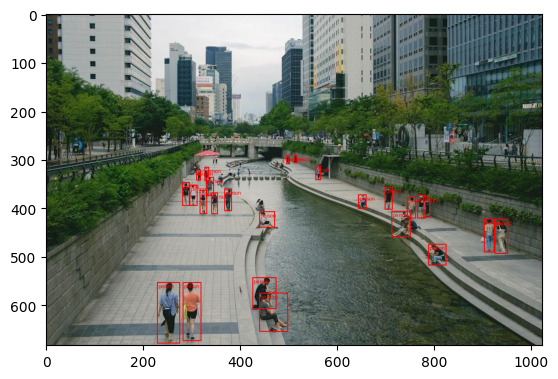

In [27]:
# 객체 ID를 순서대로 가져와 객체 이름을 매핑합니다.
label_txts = [weights.meta["categories"][i] for i in prediction["labels"]]

# draw_bounding_boxes() 함수를 사용하여 탐지된 객체들의 위치를 표시합니다.
tensor_with_boxes = draw_bounding_boxes(img_tensor,
                          boxes=prediction["boxes"],
                          labels=label_txts,
                          colors="red",
                          width=2)

# draw_bounding_boxes()는 Tensor를 반환하므로, 시각화를 위해 PIL.Image로 변환합니다.
img_with_boxes = F.to_pil_image(tensor_with_boxes)
plt.imshow(img_with_boxes)

뭔가 빼곡하게 빨간 박스가 쳐진걸 보니 이것저것 찾은 것 같습니다. 이미지를 조금 더 키워보겠습니다.

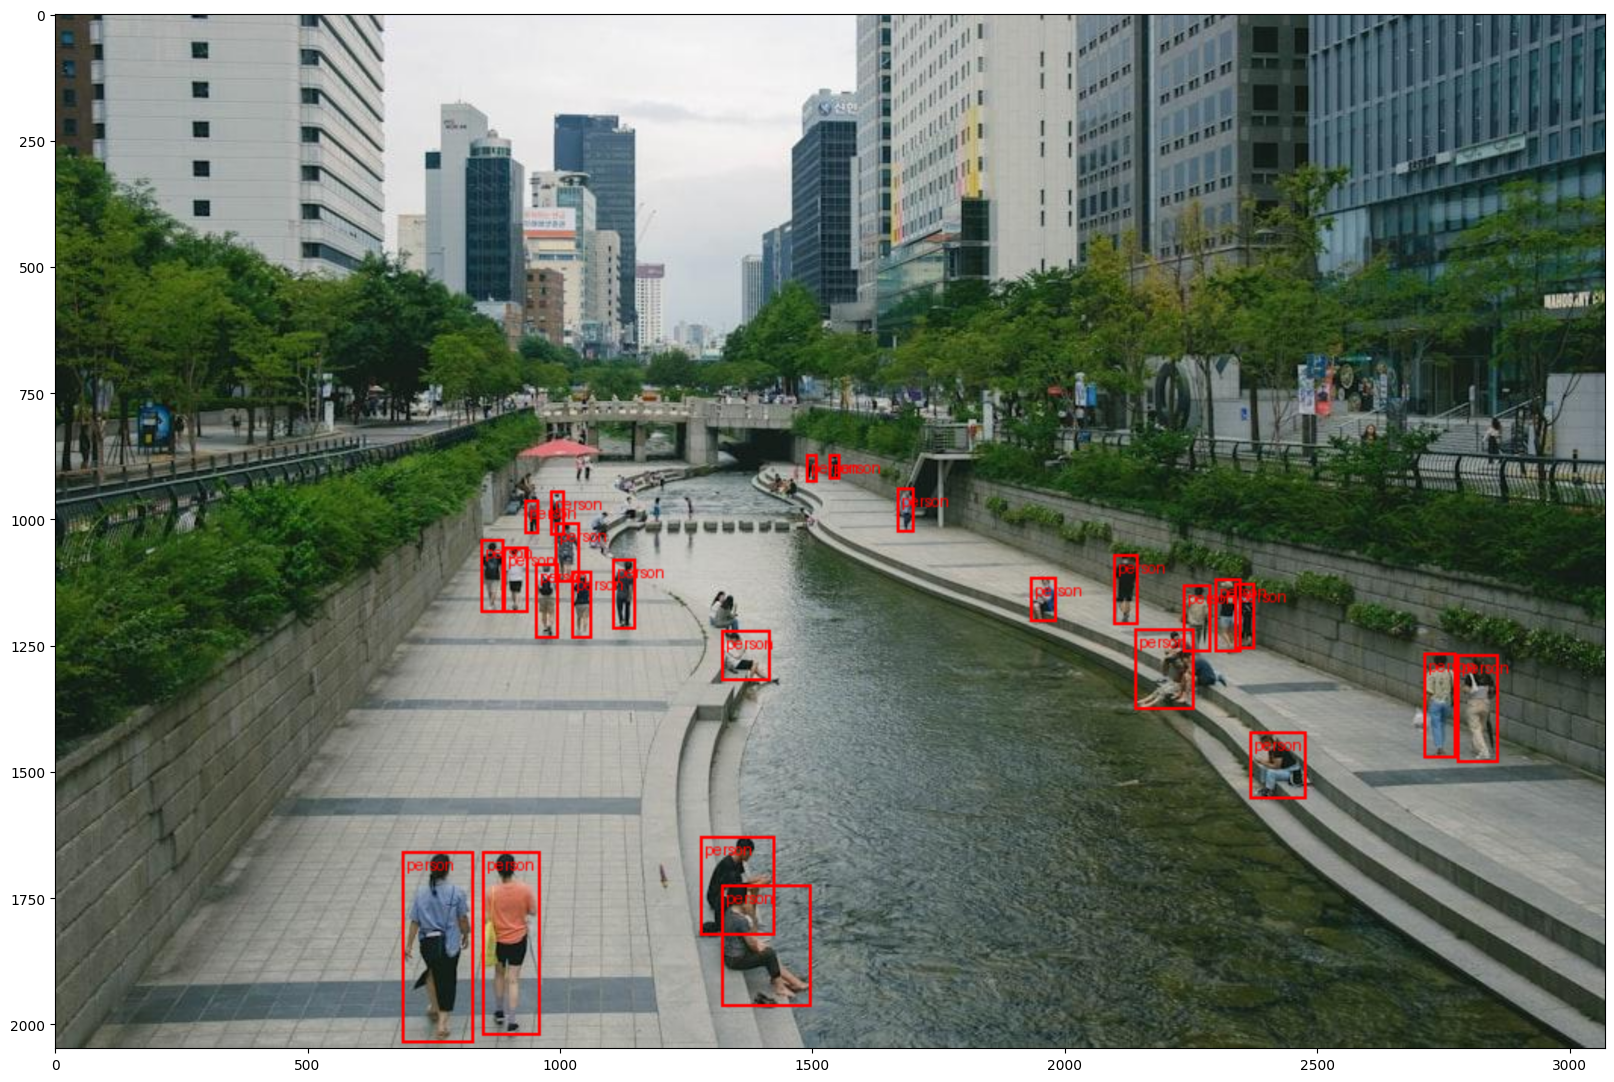

In [42]:
# 이미지의 크기를 변경합니다.
resized_image = F.resize(img_with_boxes, [2048,])

# 이미지를 표시합니다.
plt.figure(figsize=(20,18))
plt.imshow(resized_image)

## 실습 과제

- 다른 이미지를 사용하여 객체 탐지를 해보세요.
- 모델에 한꺼번에 2개 이상의 이미지를 입력으로 넣으려면 어떻게 해야 할까요?
- 사전 학습 모델의 `box_score_thresh` 값을 0.0~1.0 사이의 실수값으로 바꿔보며 결과를 확인해보세요.